In [193]:
# Importing dependencies
import pandas as pd
import numpy as np
# import OpenBlender
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password


In [219]:
sentiment_scores_df = pd.read_csv('reddit_comments_agg.csv')
sentiment_scores_df = sentiment_scores_df[1:]
sentiment_scores_df['normalised_date_dt64'] = [pd.to_datetime(x, format='%Y-%m-%d') for x in sentiment_scores_df['normalised_date']]
sentiment_scores_df.set_index(sentiment_scores_df['normalised_date_dt64'], inplace=True)
sentiment_scores_df2 = sentiment_scores_df.drop(columns=['normalised_date_dt64'])
sentiment_scores_df2.head()

,normalised_date,score,neg,neu,pos,compound,rolling
normalised_date_dt64,,,,,,,
2012-01-01,2012-01-01,3.333333,0.046400,0.893367,0.060233,0.086240,0.121112
2012-01-02,2012-01-02,2.121951,0.079707,0.818707,0.101561,0.042127,0.078388
2012-01-03,2012-01-03,2.590909,0.080000,0.817523,0.102477,0.029139,0.035952
2012-01-04,2012-01-04,2.725000,0.078175,0.833075,0.088750,0.049387,0.051089
2012-01-05,2012-01-05,3.585366,0.058146,0.846829,0.094976,0.170327,0.195525


In [195]:
# Read in files
df = pd.read_csv('bitcoin_data.csv')

# Display initial data
df.head(10)

# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price', 'Open', 'Close']].reset_index(drop=True)

# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)

# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")

final_df.head(5)

# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC'
                 }, axis='columns', inplace=True)


# Checking datatypes
print(final_df.dtypes)
final_df.head(2)

Percentage of total Bitstamp data lost due to dropping rows with NaN values: 27.14%
Ratio of Bitstamp rows dropped: 1,240,496/4,571,033
Total dataset contains 3174.33 days worth of data. Due to data loss, we had to drop 861.46 days worth of data
timestamp                 int64
high                    float64
low                     float64
volume                  float64
weightedPrice           float64
Open                    float64
Close                   float64
timestampSTR             object
timestampINT              int32
timeUTC          datetime64[ns]
dtype: object


,timestamp,high,low,volume,weightedPrice,Open,Close,timestampSTR,timestampINT,timeUTC
0,1325391360,4.58,4.58,1.502,4.58,4.58,4.58,1325391360,1325391360,2012-01-01 04:16:00
1,1325431680,4.84,4.84,10.000,4.84,4.84,4.84,1325431680,1325431680,2012-01-01 15:28:00


In [196]:
final_df['normalised_date'] = final_df['timeUTC'].dt.normalize()
final_df.head()

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampSTR,timestampINT,timeUTC,normalised_date
0,1325391360,4.58,4.58,1.502000,4.58,4.58,4.58,1325391360,1325391360,2012-01-01 04:16:00,2012-01-01
1,1325431680,4.84,4.84,10.000000,4.84,4.84,4.84,1325431680,1325431680,2012-01-01 15:28:00,2012-01-01
2,1325457900,5.00,5.00,10.100000,5.00,5.00,5.00,1325457900,1325457900,2012-01-01 22:45:00,2012-01-01
3,1325534640,5.00,5.00,19.048000,5.00,5.00,5.00,1325534640,1325534640,2012-01-02 20:04:00,2012-01-02
4,1325591100,5.32,5.32,2.419173,5.32,5.32,5.32,1325591100,1325591100,2012-01-03 11:45:00,2012-01-03


In [197]:
final_df['date_only'] = final_df['normalised_date']
# aggregated_df = final_df.groupby(final_df.normalised_date.dt.date, as_index=False).mean()

# use this line to keep dates as Series
# aggregated_df1 = final_df.groupby(final_df.normalised_date.dt.date, as_index=True).mean().reset_index()
# indices = aggregated_df1['normalised_date']

# dataframe with Time Series index
aggregated_df = final_df.groupby(final_df.normalised_date.dt.date, as_index=True).mean()

In [198]:
aggregated_df

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampINT
normalised_date,,,,,,,,
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,4.806667,4.806667,1.325427e+09
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,5.000000,5.000000,1.325535e+09
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,5.252500,5.252500,1.325605e+09
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,5.200000,5.223333,1.325682e+09
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,6.281429,6.286190,1.325771e+09
...,...,...,...,...,...,...,...,...
2020-09-10,1.599739e+09,10343.558552,10334.291588,7.119214,10339.359896,10338.759708,10338.760864,1.599739e+09
2020-09-11,1.599826e+09,10306.071361,10299.283936,3.660672,10303.242947,10302.414327,10302.451926,1.599826e+09
2020-09-12,1.599912e+09,10375.469839,10370.388713,1.754713,10373.259995,10372.770434,10372.583252,1.599912e+09


In [199]:
aggregated_df = pd.concat([aggregated_df,sentiment_scores_df], axis=1, join='inner')
aggregated_df.head()

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampINT,normalised_date,score,neg,neu,pos,compound,rolling,normalised_date_dt64
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,4.806667,4.806667,1.325427e+09,2012-01-01,3.333333,0.046400,0.893367,0.060233,0.086240,0.121112,2012-01-01
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,5.000000,5.000000,1.325535e+09,2012-01-02,2.121951,0.079707,0.818707,0.101561,0.042127,0.078388,2012-01-02
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,5.252500,5.252500,1.325605e+09,2012-01-03,2.590909,0.080000,0.817523,0.102477,0.029139,0.035952,2012-01-03
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,5.200000,5.223333,1.325682e+09,2012-01-04,2.725000,0.078175,0.833075,0.088750,0.049387,0.051089,2012-01-04
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,6.281429,6.286190,1.325771e+09,2012-01-05,3.585366,0.058146,0.846829,0.094976,0.170327,0.195525,2012-01-05


In [200]:
aggregated_df

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampINT,normalised_date,score,neg,neu,pos,compound,rolling,normalised_date_dt64
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,4.806667,4.806667,1.325427e+09,2012-01-01,3.333333,0.046400,0.893367,0.060233,0.086240,0.121112,2012-01-01
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,5.000000,5.000000,1.325535e+09,2012-01-02,2.121951,0.079707,0.818707,0.101561,0.042127,0.078388,2012-01-02
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,5.252500,5.252500,1.325605e+09,2012-01-03,2.590909,0.080000,0.817523,0.102477,0.029139,0.035952,2012-01-03
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,5.200000,5.223333,1.325682e+09,2012-01-04,2.725000,0.078175,0.833075,0.088750,0.049387,0.051089,2012-01-04
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,6.281429,6.286190,1.325771e+09,2012-01-05,3.585366,0.058146,0.846829,0.094976,0.170327,0.195525,2012-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,1.599739e+09,10343.558552,10334.291588,7.119214,10339.359896,10338.759708,10338.760864,1.599739e+09,2020-09-10,1.900000,0.065841,0.835543,0.098622,0.170521,0.165506,2020-09-10
2020-09-11,1.599826e+09,10306.071361,10299.283936,3.660672,10303.242947,10302.414327,10302.451926,1.599826e+09,2020-09-11,1.515260,0.068309,0.821795,0.109898,0.147518,0.141176,2020-09-11
2020-09-12,1.599912e+09,10375.469839,10370.388713,1.754713,10373.259995,10372.770434,10372.583252,1.599912e+09,2020-09-12,3.245926,0.065944,0.828458,0.105636,0.152564,0.165354,2020-09-12
2020-09-13,1.599999e+09,10396.386007,10390.076996,3.056612,10393.662602,10393.230099,10392.960134,1.599999e+09,2020-09-13,3.279534,0.064995,0.831902,0.103080,0.144426,0.145943,2020-09-13


In [201]:
date_price_df = aggregated_df[['weightedPrice']]
daily_deltas = date_price_df.pct_change(periods=1)
# monthly_deltas = date_price_df.pct_change(freq='M')
#aggregated_df['pct_change'] = aggregated_df.pct_change('weightedPrice', periods=1, index='normalised_date')

In [202]:
date_price_df['daily_pct_change'] = daily_deltas
date_price_df

<ipython-input-202-41a1d4bb9d51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_price_df['daily_pct_change'] = daily_deltas


,weightedPrice,daily_pct_change
2012-01-01,4.806667,NaN
2012-01-02,5.000000,0.040222
2012-01-03,5.252500,0.050500
2012-01-04,5.208159,-0.008442
2012-01-05,6.284127,0.206593
...,...,...
2020-09-10,10339.359896,0.014840
2020-09-11,10303.242947,-0.003493
2020-09-12,10373.259995,0.006796
2020-09-13,10393.662602,0.001967


In [203]:
len(date_price_df)

3177

In [204]:
# Creating the time-series index
n=len(date_price_df)
index = pd.date_range('2012-01-01', periods = n,freq='D')
index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
               '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11'],
              dtype='datetime64[ns]', length=3177, freq='D')

In [205]:
date_price_df = date_price_df.set_index(index)

In [206]:
# finding monthly % change
monthly = date_price_df.resample('BM').apply(lambda x: x[-1])
monthly.drop(columns=['daily_pct_change'], inplace=True)
monthly['monthly_pct_change'] = monthly.pct_change()
monthly

,weightedPrice,monthly_pct_change
2012-01-31,5.614045,NaN
2012-02-29,4.952722,-0.117798
2012-03-30,4.836740,-0.023418
2012-04-30,4.950282,0.023475
2012-05-31,5.136571,0.037632
...,...,...
2020-05-29,9585.242823,0.067412
2020-06-30,9093.863232,-0.051264
2020-07-31,11255.501070,0.237703
2020-08-31,11039.063579,-0.019229


In [207]:
three_months= date_price_df.resample('3M').apply(lambda x: x[-1])
three_months.drop(columns=['daily_pct_change'], inplace=True)
#three_months['quarterly_pct_change'] = three_months['daily_pct_change']

three_months['quarterly_pct_change'] = three_months.pct_change()
three_months

,weightedPrice,quarterly_pct_change
2012-01-31,5.614045,NaN
2012-04-30,4.950282,-0.118233
2012-07-31,9.199746,0.858429
2012-10-31,10.826328,0.176807
2013-01-31,20.230478,0.868637
2013-04-30,141.614016,6.000033
2013-07-31,98.923727,-0.301455
2013-10-31,200.809802,1.029946
2014-01-31,801.904549,2.993354
2014-04-30,445.661972,-0.444246


In [208]:
yearly = date_price_df.resample('Y').apply(lambda x: x[-1])
yearly.drop(columns=['daily_pct_change'], inplace=True)
# yearly['yearly_pct_change'] = yearly['daily_pct_change']
yearly['yearly_pct_change'] = yearly.pct_change()
yearly

,weightedPrice,yearly_pct_change
2012-12-31,13.196513,NaN
2013-12-31,728.728912,54.221323
2014-12-31,314.514811,-0.568406
2015-12-31,429.069676,0.364227
2016-12-31,1019.992995,1.377220
2017-12-31,14962.379078,13.669100
2018-12-31,3829.104391,-0.744085
2019-12-31,7218.040867,0.885047
2020-12-31,10332.429402,0.431473


In [209]:
date_price_merged = pd.merge(left=date_price_df, right=monthly, how='left')
date_price_merged['dt_index'] = index
date_price_merged

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index
0,4.806667,NaN,NaN,2012-01-01
1,5.000000,0.040222,NaN,2012-01-02
2,5.252500,0.050500,NaN,2012-01-03
3,5.208159,-0.008442,NaN,2012-01-04
4,6.284127,0.206593,NaN,2012-01-05
...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07
3173,10303.242947,-0.003493,NaN,2020-09-08
3174,10373.259995,0.006796,NaN,2020-09-09
3175,10393.662602,0.001967,NaN,2020-09-10


In [210]:
date_price_merged = pd.merge(left=date_price_merged, right=yearly, how='left')
date_price_merged

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index,yearly_pct_change
0,4.806667,NaN,NaN,2012-01-01,NaN
1,5.000000,0.040222,NaN,2012-01-02,NaN
2,5.252500,0.050500,NaN,2012-01-03,NaN
3,5.208159,-0.008442,NaN,2012-01-04,NaN
4,6.284127,0.206593,NaN,2012-01-05,NaN
...,...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07,NaN
3173,10303.242947,-0.003493,NaN,2020-09-08,NaN
3174,10373.259995,0.006796,NaN,2020-09-09,NaN
3175,10393.662602,0.001967,NaN,2020-09-10,NaN


In [211]:
date_price_merged.iloc[59]

weightedPrice                     4.95272
daily_pct_change              -0.00779485
monthly_pct_change              -0.117798
dt_index              2012-02-29 00:00:00
yearly_pct_change                     NaN
Name: 59, dtype: object

In [212]:
log_diffs = aggregated_df[['Open','Close']]
# date_price_merged['daily_log_diff'] = np.log(log_diffs['Close']) - np.log(log_diffs['Open'])
date_price_merged['daily_log_diff'] = [np.log(x)- np.log(y) for x,y in zip(log_diffs['Close'], log_diffs['Open'])]

In [213]:
# log diff can be interpreted as an approximation of "percentage change"
date_price_merged

# for visualization purposes, might be interesting to plot normal weightedPrice vs Time, daily_log_diff vs Time, and a log_diff histogram
# when presenting, can filter by month/year to better observe changes within each year

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index,yearly_pct_change,daily_log_diff
0,4.806667,NaN,NaN,2012-01-01,NaN,0.000000e+00
1,5.000000,0.040222,NaN,2012-01-02,NaN,0.000000e+00
2,5.252500,0.050500,NaN,2012-01-03,NaN,0.000000e+00
3,5.208159,-0.008442,NaN,2012-01-04,NaN,4.477142e-03
4,6.284127,0.206593,NaN,2012-01-05,NaN,7.578054e-04
...,...,...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07,NaN,1.118112e-07
3173,10303.242947,-0.003493,NaN,2020-09-08,NaN,3.649569e-06
3174,10373.259995,0.006796,NaN,2020-09-09,NaN,-1.804566e-05
3175,10393.662602,0.001967,NaN,2020-09-10,NaN,-2.597539e-05


In [214]:
# creating our targets (1 for net pct increase, 0 for no change/decrease)
# our target predicts whether or not there is positive performance
date_price_merged['target'] = [1 if x > 0 else 0 for x in date_price_merged['daily_log_diff']]
date_price_merged

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index,yearly_pct_change,daily_log_diff,target
0,4.806667,NaN,NaN,2012-01-01,NaN,0.000000e+00,0
1,5.000000,0.040222,NaN,2012-01-02,NaN,0.000000e+00,0
2,5.252500,0.050500,NaN,2012-01-03,NaN,0.000000e+00,0
3,5.208159,-0.008442,NaN,2012-01-04,NaN,4.477142e-03,1
4,6.284127,0.206593,NaN,2012-01-05,NaN,7.578054e-04,1
...,...,...,...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07,NaN,1.118112e-07,1
3173,10303.242947,-0.003493,NaN,2020-09-08,NaN,3.649569e-06,1
3174,10373.259995,0.006796,NaN,2020-09-09,NaN,-1.804566e-05,0
3175,10393.662602,0.001967,NaN,2020-09-10,NaN,-2.597539e-05,0


In [215]:
# can use OpenBlender (NLP) to supplement findings with news articles, vectorize input parameters as 1 and 0

In [216]:
# applying ML model and observing results
# importing dependencies
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [217]:
# temporarily dropping monthly/annual log calculations since they contain NaN values
# also dropping very 1st value (cannot calculate deltas from nothing)
date_price_merged2 = date_price_merged.drop(columns=['monthly_pct_change','yearly_pct_change'])
date_price_merged2 = date_price_merged2.iloc[1:]
date_price_merged2

,weightedPrice,daily_pct_change,dt_index,daily_log_diff,target
1,5.000000,0.040222,2012-01-02,0.000000e+00,0
2,5.252500,0.050500,2012-01-03,0.000000e+00,0
3,5.208159,-0.008442,2012-01-04,4.477142e-03,1
4,6.284127,0.206593,2012-01-05,7.578054e-04,1
5,6.438999,0.024645,2012-01-06,1.552795e-03,1
...,...,...,...,...,...
3172,10339.359896,0.014840,2020-09-07,1.118112e-07,1
3173,10303.242947,-0.003493,2020-09-08,3.649569e-06,1
3174,10373.259995,0.006796,2020-09-09,-1.804566e-05,0
3175,10393.662602,0.001967,2020-09-10,-2.597539e-05,0


In [220]:
date_price_merged3 = date_price_merged2.set_index(date_price_merged2['dt_index'])
date_price_merged3

,weightedPrice,daily_pct_change,dt_index,daily_log_diff,target
dt_index,,,,,
2012-01-02,5.000000,0.040222,2012-01-02,0.000000e+00,0
2012-01-03,5.252500,0.050500,2012-01-03,0.000000e+00,0
2012-01-04,5.208159,-0.008442,2012-01-04,4.477142e-03,1
2012-01-05,6.284127,0.206593,2012-01-05,7.578054e-04,1
2012-01-06,6.438999,0.024645,2012-01-06,1.552795e-03,1
...,...,...,...,...,...
2020-09-07,10339.359896,0.014840,2020-09-07,1.118112e-07,1
2020-09-08,10303.242947,-0.003493,2020-09-08,3.649569e-06,1
2020-09-09,10373.259995,0.006796,2020-09-09,-1.804566e-05,0


In [240]:
date_price_merged2.columns

Index(['weightedPrice', 'daily_pct_change', 'dt_index', 'daily_log_diff',
       'target', 'score', 'neg', 'neu', 'pos', 'compound', 'rolling'],
      dtype='object')

In [250]:
date_price_merged2 = pd.concat([date_price_merged3, sentiment_scores_df2], axis=1, join='inner')
date_price_merged2.drop(columns=['normalised_date','weightedPrice','daily_pct_change','dt_index','daily_log_diff'], inplace=True)
date_price_merged2

,target,score,neg,neu,pos,compound,rolling
2012-01-02,0,2.121951,0.079707,0.818707,0.101561,0.042127,0.078388
2012-01-03,0,2.590909,0.080000,0.817523,0.102477,0.029139,0.035952
2012-01-04,1,2.725000,0.078175,0.833075,0.088750,0.049387,0.051089
2012-01-05,1,3.585366,0.058146,0.846829,0.094976,0.170327,0.195525
2012-01-06,1,2.063830,0.063638,0.825553,0.110809,0.210717,0.185822
...,...,...,...,...,...,...,...
2020-09-07,1,1.257449,0.068073,0.825540,0.106390,0.156567,0.155254
2020-09-08,1,1.080357,0.067413,0.823720,0.108853,0.185623,0.182260
2020-09-09,0,1.156284,0.065800,0.831169,0.103004,0.156549,0.160828
2020-09-10,0,1.900000,0.065841,0.835543,0.098622,0.170521,0.165506


In [251]:
# creating training and testing datasets
df = date_price_merged2
X = df.loc[:,df.columns != 'target'].select_dtypes(include=[np.number]).values
y = df.loc[:,['target']].values

div = int(round(len(X) * 0.2)) # allocating 20% of dataset for testing
X_train = X[:div]
y_train = y[:div]
X_test = X[div:]
y_test= y[div:]

In [252]:
# creating random forest classifier
cls = RandomForestRegressor(n_estimators=1000)
cls.fit(X_train, np.ravel(y_train, order='C'))
y_pred = cls.predict(X_test)

df_residuals = pd.DataFrame({'y_test':y_test[:, 0], 'y_pred':y_pred})
df_residuals

,y_test,y_pred
0,1,0.366
1,1,0.433
2,1,0.320
3,1,0.715
4,1,0.495
...,...,...
2536,1,0.323
2537,1,0.615
2538,0,0.436
2539,0,0.590


In [253]:
# calculating base model's accuracy based on only 'weightedPrice' and 'daily_pct_change'
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in df_residuals['y_pred']]
print(confusion_matrix(predictions, df_residuals['y_test']))

print('Accuracy score: ')
print(accuracy_score(predictions, df_residuals['y_test']))

print('Precision score: ')
print(precision_score(predictions, df_residuals['y_test']))

[[587 688]
 [622 644]]
Accuracy score: 
0.48445493900039355
Precision score: 
0.48348348348348347


In [254]:
# based on the confusion matrix, there were 1329 total daily price increase events
# our model predicted 1329 + 3 = 1,332 total price increase events, where 3 were False Positives
# there were a total of 1,209 + 3 = 1,212 total price DECREASE events, our model detected 1,209 and missed 3 events

# precision: high precision indicates low false positive rate, also known as ratio of correctly predicted positive observations to all observations in total class
# accuracy: high accuracy indicates the ratio of correct predictions made out of total observations

In [255]:
# comparing multiple models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [256]:
# calculating optimal hyperparameters for random forest classifier based on RandomSearchCV

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in range(20,2021,200)] #trees per forest
max_features = ['auto', 'sqrt', 'log2', None]
max_depth = [int(x) for x in range(10,111,10)] #tree depth
max_depth.append(None)

min_samples_split = [2, 4, 6, 10]
min_samples_leaf = [1, 2, 4, 6, 8]
bootstrap = [True, False]

# input grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [20, 220, 420, 620, 820, 1020, 1220, 1420, 1620, 1820, 2020], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 4, 6, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False]}


In [257]:
# after generating random input grid, create base model
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                    param_distributions=random_grid,
                    n_iter=100,
                    cv=3,
                    refit=True,
                    verbose=3,
                    error_score=0,
                    n_jobs=-1)

In [258]:
# training model 
rf_random.fit(X_train, np.ravel(y_train, order='C'))

# viewing the best parameters from cross validation
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 1620,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [259]:
# creating our random forest classifier with tuned hyperparameters
best_random = rf_random.best_estimator_
best_random

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=8,
                       n_estimators=1620)

In [260]:
def compare_models(X_train, y_train, X_test, y_test):
  models = [
            ('LogReg', LogisticRegression()),
            ('RF', RandomForestClassifier()),
            ('KNN', KNeighborsClassifier()),
            ('SVC', SVC()),
            ('GNB', GaussianNB()),
            ('XGB', XGBClassifier()),
            ('oRF', best_random)
  ]

  dfs = []
  results = []
  names = []
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
  target_names = ['increase', 'decrease']


# performing K-Fold cross validation 
  for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))

    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
  
  final = pd.concat(dfs, ignore_index=True)
  return final

In [261]:
final = compare_models(X_train, np.ravel(y_train, order='C'), X_test, y_test)
final

c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c

LogReg
              precision    recall  f1-score   support

    increase       0.48      1.00      0.64      1209
    decrease       0.00      0.00      0.00      1332

    accuracy                           0.48      2541
   macro avg       0.24      0.50      0.32      2541
weighted avg       0.23      0.48      0.31      2541

RF
              precision    recall  f1-score   support

    increase       0.48      0.60      0.53      1209
    decrease       0.53      0.41      0.46      1332

    accuracy                           0.50      2541
   macro avg       0.50      0.50      0.50      2541
weighted avg       0.50      0.50      0.49      2541

KNN
              precision    recall  f1-score   support

    increase       0.47      0.47      0.47      1209
    decrease       0.52      0.52      0.52      1332

    accuracy                           0.50      2541
   macro avg       0.50      0.50      0.50      2541
weighted avg       0.50      0.50      0.50      2541



c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c

SVC
              precision    recall  f1-score   support

    increase       0.48      1.00      0.64      1209
    decrease       0.00      0.00      0.00      1332

    accuracy                           0.48      2541
   macro avg       0.24      0.50      0.32      2541
weighted avg       0.23      0.48      0.31      2541

GNB
              precision    recall  f1-score   support

    increase       0.46      0.70      0.56      1209
    decrease       0.49      0.26      0.34      1332

    accuracy                           0.47      2541
   macro avg       0.47      0.48      0.45      2541
weighted avg       0.48      0.47      0.44      2541

[22:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\patrick\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
              precision    recall  f1-score   support

    increase       0.48      0.46      0.47      1209
    decrease       0.53      0.54      0.53      1332

    accuracy                           0.50      2541
   macro avg       0.50      0.50      0.50      2541
weighted avg       0.50      0.50      0.50      2541

oRF
              precision    recall  f1-score   support

    increase       0.48      0.75      0.59      1209
    decrease       0.54      0.26      0.35      1332

    accuracy                           0.50      2541
   macro avg       0.51      0.51      0.47      2541
weighted avg       0.51      0.50      0.46      2541



,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.017709,0.008068,0.574803,0.330399,0.574803,0.419606,0.534500,LogReg
1,0.014015,0.006372,0.566929,0.321409,0.566929,0.410240,0.466919,LogReg
2,0.013231,0.006391,0.582677,0.339513,0.582677,0.429036,0.470168,LogReg
3,0.010161,0.006420,0.559055,0.312543,0.559055,0.400939,0.464789,LogReg
4,0.010543,0.006638,0.598425,0.358113,0.598425,0.448082,0.439370,LogReg
5,0.304816,0.041086,0.440945,0.403281,0.440945,0.390312,0.488834,RF
6,0.283618,0.040808,0.511811,0.475899,0.511811,0.476530,0.468924,RF
7,0.283640,0.041115,0.527559,0.508534,0.527559,0.507589,0.508965,RF
8,0.277180,0.044840,0.519685,0.517563,0.519685,0.518594,0.448670,RF
9,0.289427,0.040615,0.566929,0.552145,0.566929,0.555367,0.589138,RF


In [262]:
# dynamically generate columns for visualizing

bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Model Classifier Comparisons')

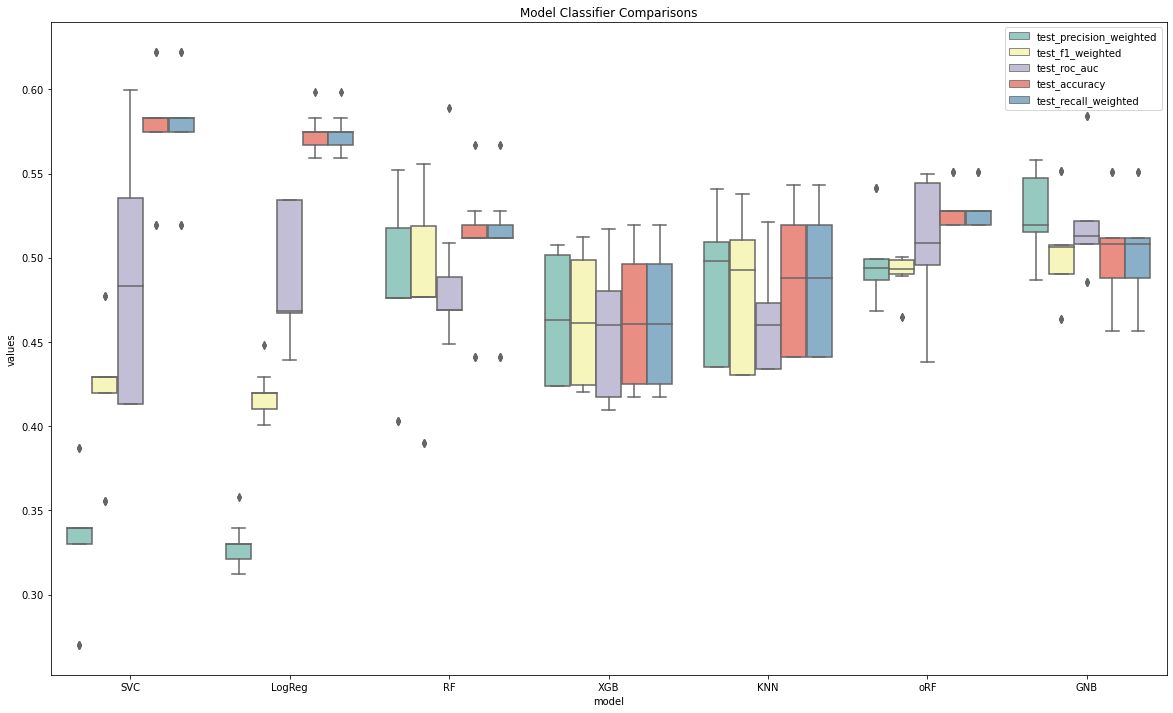

In [263]:
# visualizing model classifier performance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
fig = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(loc=0)
plt.title('Model Classifier Comparisons')

Text(0.5, 1.0, 'Model Training & Prediction Time Comparison')

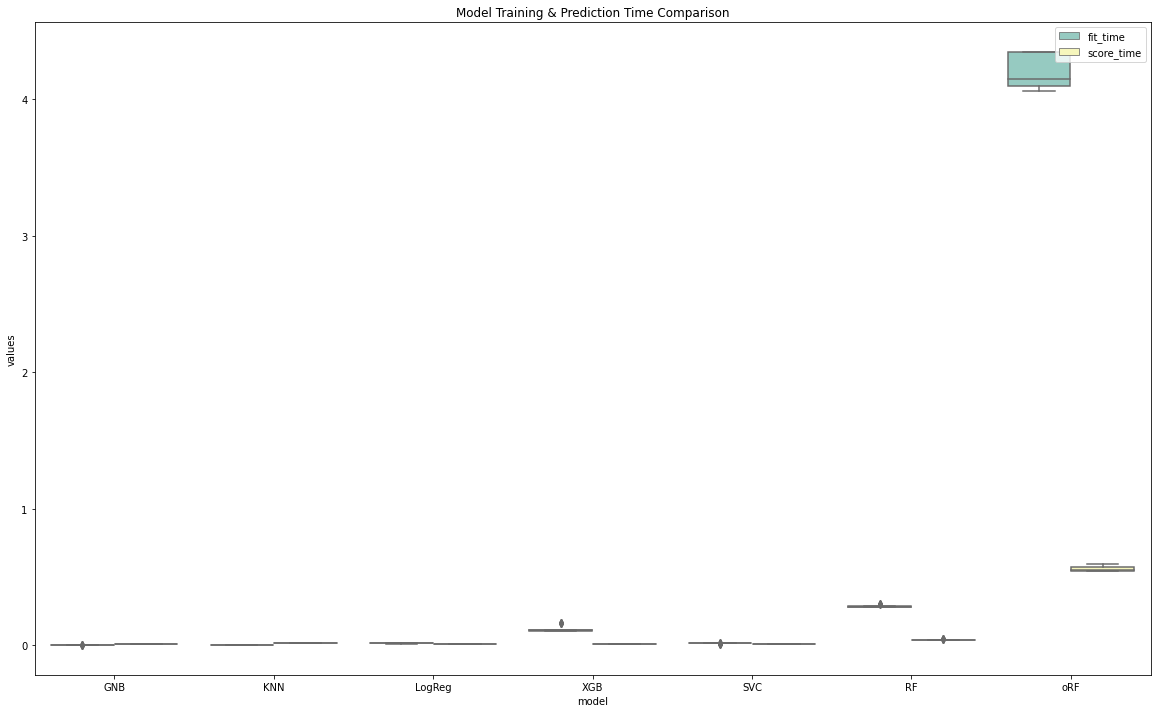

In [264]:
# visualizing training and scoring times
plt.figure(figsize=(20, 12))
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(loc=0)
plt.title('Model Training & Prediction Time Comparison')

# notes for further analysis -- consider Neural Network which generally takes large amounts of data/time to train, but might yield better results

In [265]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_roc_auc           test_accuracy           test_recall_weighted  \
                std      mean           std      mean                  std   
model                                                                        
GNB        0.032410  0.523152      0.029249  0.505249             0.029249   
KNN        0.031969  0.466671      0.041611  0.490289             0.041611   
LogReg     0.034194  0.488009      0.009416  0.573753             0.009416   
RF         0.040252  0.484877      0.034979  0.509449             0.034979   
SVC        0.067208  0.486802      0.030489  0.576378             0.030489   
XGB        0.041078  0.460387      0.043132  0.463255             0.043132   
oRF        0.040864  0.502484      0.012143  0.530446             0.012143   

                 test_precision_weighted           test_f1_weighted            
            mean                     std      mean              std      mean  
model                                                                          
GNB     0.505249                0.022578  0.524502         0.027302  0.505757  
KNN     0.490289                0.041290  0.486046         0.043523  0.483595  
LogReg  0.573753                0.010892  0.329279         0.011272  0.418398  
RF      0.509449                0.044512  0.485494         0.049265  0.484000  
SVC     0.576378                0.034679  0.333110         0.036168  0.421951  
XGB     0.463255                0.041012  0.464197         0.041485  0.463081  
oRF     0.530446                0.024213  0.501268         0.009910  0.491774